## OOI Endurance Array

![Endurance Array](https://ooinet.oceanobservatories.org/img/home/coastal_endurance/endurance_1.jpg) 

This example focuses on Acoustic Doppler Current Profiler (ADCP) data from the inshore mooring on the Oregon line. The ADCP is mounted at the bottom and looks upward throughout the water column, measuring velocity at a series of depths.

![Oregon Endurance Line](https://ooinet.oceanobservatories.org/img/home/coastal_endurance/endurance_2.png)


The photo below shows an ADCP deployed at the OOI Axial Seamount site. The four red cylinders are the upward-facing transducers, which send and receive acoustic signals. Image source: https://oceanobservatories.org/instrument-class/adcp/

![ADCP photo](https://oceanobservatories.org/wp-content/uploads/2016/10/adcp.r1735_sdi1_2014-08-040_45_40_14317_spacialrelationshipoflv01atolj01a_med.jpg)

The [OOI Data Portal](https://ooinet.oceanobservatories.org/) can be used to access data from any OOI instrument. The data typically come in NetCDF format. To create a custom data catalog, you need to sign up for a free account.

A data catalog for the bottom-mounted ADCP at the Oregon inshore mooring has already been created:

https://opendap.oceanobservatories.org/thredds/catalog/ooi/tconnolly@mlml.calstate.edu/20200421T020908490Z-CE01ISSM-MFD37-03-CTDBPC000-recovered_inst-ctdbp_cdef_instrument_recovered/catalog.html

### Load data

In addition to standard libraries, the `import tseries as ts` line imports the module contained in the file `tseries.py` contained in this repository.

In [1]:
#%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from matplotlib import mlab
import scipy.signal as signal

import tseries as ts

In [2]:
thredds_dataset = 'https://opendap.oceanobservatories.org/thredds/dodsC/ooi/tconnolly@mlml.calstate.edu/20200320T020213155Z-CE01ISSM-MFD35-04-ADCPTM000-recovered_inst-adcp_velocity_earth/deployment0009_CE01ISSM-MFD35-04-ADCPTM000-recovered_inst-adcp_velocity_earth_20180403T043000-20180912T224545.920000.nc'
local_dataset = 'ooi_data/deployment0009_CE01ISSM-MFD35-04-ADCPTM000-recovered_inst-adcp_velocity_earth_20180403T043000-20180912T224545.920000.nc'

The ADCP data for April-September 2018 is included in this repository. The data set is in NetCDF format, and can be easily opened with the [xarray](http://xarray.pydata.org) package.

In [4]:
ds = xr.open_dataset(local_dataset)

Another option is to access the data set remotely, using the OOI THREDDS server. This alternative can be used with the following code:

```python
ds = xr.open_dataset(thredds_dataset+'#fillmismatch')
```

In [9]:
ds['water_velocity_east']

<xarray.DataArray 'water_velocity_east' (obs: 7811, bin: 30)>
[234330 values with dtype=float32]
Coordinates:
  * obs      (obs) int32 0 1 2 3 4 5 6 7 ... 7804 7805 7806 7807 7808 7809 7810
Dimensions without coordinates: bin
Attributes:
    comment:                  A Velocity Profile includes water velocity (spe...
    long_name:                Eastward Seawater Velocity
    precision:                0
    coordinates:              time lat lon pressure
    data_product_identifier:  VELPROF-VLE_L0
    standard_name:            eastward_sea_water_velocity
    units:                    mm s-1

### ADCP post-processing

First, for convenience, create variables for eastward velocity ($u$) and northward velocity ($v$) in units of m/s.

In [10]:
ds['u'] = ds['water_velocity_east']/1000
ds['u'].attrs['units'] = 'm/s'

ds['v'] = ds['water_velocity_north']/1000
ds['v'].attrs['units'] = 'm/s'


The dataset provided by OOI includes the following variables:
* `depth_from_pressure` is the total water column depth, calculated from the pressure sensor. Dimensions: `(obs)`
* `bin_depths` is the depth of each ADCP bin below the sea surface, which moves up and down. The bin depths constantly change in time. Dimensions: `(obs, bin)`

The code below creates additional variables for keeping track of depths in the ADCP data:
* `bin_height` is the height of each ADCP bin above the bottom. These heights are fixed, since the ADCP is mounted at the bottom. Dimensions: `(bin)`
* `bin_depths_avg` is the average depth below the surface for each ADCP bin. These depths are fixed in time since they are defined in relation to a time average. Dimensions: `(bin)`
* `sea_surface` is the height of the sea surface, relative to the time average. Dimensions: `(obs)`
* `bottom_depth_avg` is the average bottom depth, calculated from the pressure sensor. This is a single value with no dimensions. Dimensions: `()`

In [11]:
ds['bin_height'] =  ds['depth_from_pressure'][0] - ds['bin_depths'][0,:]
ds['bin_height'].attrs['units'] = 'm'

ds['bin_depths_avg'] = ds['bin_height']-np.mean(ds['depth_from_pressure'])
ds['bin_depths_avg'].attrs['units'] = 'm'

ds['sea_surface'] = ds['depth_from_pressure']-np.mean(ds['depth_from_pressure'])
ds['sea_surface'].attrs['units'] = 'm'

ds['bottom_depth_avg'] = np.mean(ds['depth_from_pressure'])
ds['bottom_depth_avg'].attrs['units'] = 'm'

### ADCP quality control

The acoustic signal of the ADCP can be reflected at the sea surface, leading to contamination. This plot shows the echo intensity for one of the four beams of the ADCP. There is bad data near the sea surface, as well as data above the sea surface which needs to be discarded.

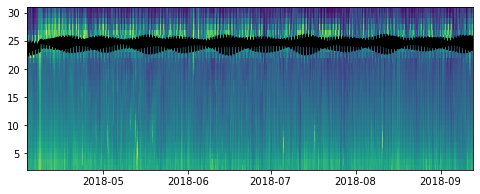

In [12]:
plt.figure(figsize=(8,3))
plt.pcolor(ds['time'],ds['bin_height'],
           ds['corrected_echo_intensity_beam1'].T)
plt.plot(ds['time'],ds['depth_from_pressure'],'k-') 

To get a better look, select a date range for plotting a subset of the data.

In [13]:
t1 = np.datetime64('2018-07-01 00:00:00')
t2 = np.datetime64('2018-07-15 00:00:00')

(736876.0, 736890.0)

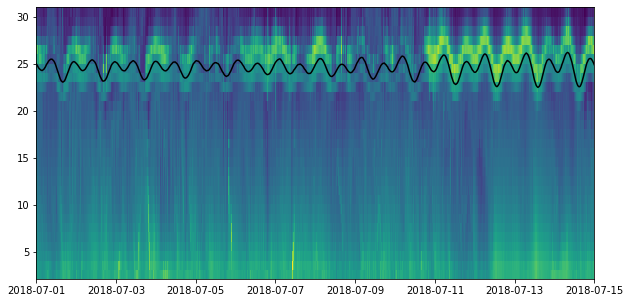

In [24]:
plt.figure(figsize=(10,5))
plt.pcolor(ds['time'],ds['bin_height'],
           ds['corrected_echo_intensity_beam1'].T)
plt.plot(ds['time'],ds['depth_from_pressure'],'k-') 
plt.xlim([t1,t2])

Looking at the velocity, the noise near the surface is apparent.

In [ ]:
plt.figure(figsize=(8,3))
# insert code here

We can remove the noise by selecting only good data at least 4m below the sea surface. 

In [18]:
good = (ds['bin_depths'] > 4)

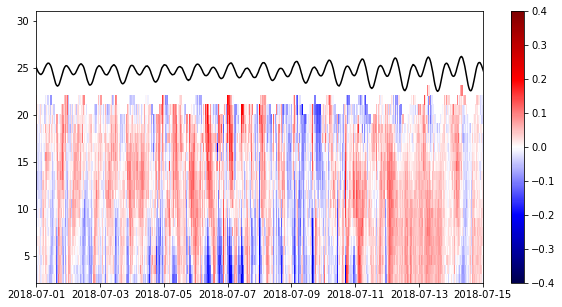

In [25]:
plt.figure(figsize=(10,5))
plt.pcolor(ds['time'],ds['bin_height'],ds['u'].where(good).T,cmap='seismic')
plt.plot(ds['time'],ds['depth_from_pressure'],'k-') # convert from dPa to dbar
plt.xlim([t1,t2])
plt.clim([-0.4,0.4])
plt.colorbar()

### Exercise

Plot the northward velocity ($v$) variable as a function of time and height above the bottom. Which velocity component tends to be stronger, the $u$ or $v$ component?

In [ ]:
# insert code here

### Compute depth-averaged velocity

The averaged of the velocity over all depths of the water column is called the depth-averaged velocity. A function for computing the depth averaged velocity is included in the `tseries.py` module.

In [20]:
uda = ts.depthavg(ds['u'].where(good),
                  ds['bin_depths_avg'],
                  ds['bottom_depth_avg'],
                  ds['sea_surface'])

vda = ts.depthavg(ds['v'].where(good),
                  ds['bin_depths_avg'],
                  ds['bottom_depth_avg'],
                  ds['sea_surface'])

ds['uda'] = xr.DataArray(uda,dims='obs')
ds['uda'].attrs['units'] = 'm/s'
ds['vda'] = xr.DataArray(vda,dims='obs')
ds['vda'].attrs['units'] = 'm/s'

In [ ]:
plt.figure()
# insert code here

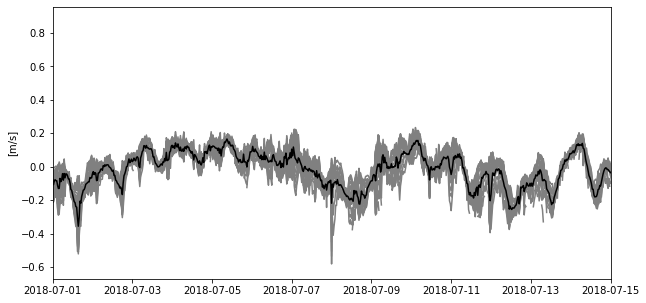

In [27]:
plt.figure(figsize=(10,5))
h1 = plt.plot(ds['time'],ds['v'].where(good),color='gray');
h2 = plt.plot(ds['time'],ds['vda'],color='k');
plt.xlim([t1,t2]);
plt.ylabel('[m/s]');

### Exercise

Make a scatter plot between the depth-averaged $\bar{u}$ and $\bar{v}$ velocity components. Which component tends to have a greater magnitude, and why?

In [ ]:
# insert code here

### Correlation functions

**Goal:** Based on the decorrelation time scale, how many *effective* degrees of freedom ($N^*$) does this time series have?

#### Preliminary exercises

How many samples ($N$) are in the depth-averaged $\bar{v}$ time series?

What is the time interval $\Delta t$ betwen samples?

*insert answer here*

#### Manually computing autocorrelation

Correlation at zero lag ($\tau$ = 0).

In [ ]:
# insert code here

Correlation at lag ($\tau$ = $\Delta t$).

In [ ]:
# insert code here

Correlation at lag ($\tau$ = 2$\Delta t$).

In [ ]:
# insert code here

In [ ]:
plt.figure()
plt.plot(ds['time'][2:],ds['vda'][2:],'r-')
plt.plot(ds['time'][2:],ds['vda'][:-2],'b-')
plt.xlim([ds['time'][0],ds['time'][100]])
plt.xticks(rotation=30)

#### Exercise

Compute the autocorrelation (r) for a lag of $\tau$ = 3 hours

In [ ]:
# insert code here

### Autocorrelation function

Computing cross-correlation and autocorrelation functions is common enough that there is a matplotlib function to plot them. This function also allows you to automatically detrend the data beforehand.

Text(0.5, 1.0, 'autocorrelation function, depth-averaged v')

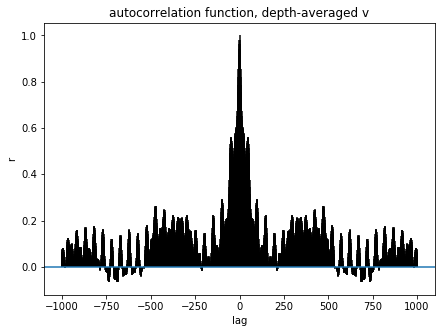

In [30]:
plt.figure(figsize=(7,5))
lags,r,_,_ = plt.xcorr(ds['vda'],ds['vda'],detrend=mlab.detrend,maxlags=1000);
plt.xlabel('lag')
plt.ylabel('r')
plt.title('autocorrelation function, depth-averaged v')

In [ ]:
lags

In [ ]:
r

#### Exercises

* From the autocorrelation plot above, estimate the decorrelation time scale (the time lag $\tau$ at which $r$ decreases to 0, in hours).
* Based on the decorrelation time scale, how many *effective* degrees of freedom ($N^*$) does this time series have?

### Spectral analysis intro

These exercises use the time series for depth-averaged velocity $\bar{v}$ and bottom pressure.

In [ ]:
plt.figure()
# insert code here

In [ ]:
plt.figure()
# insert code here

### Exercises

* How many samples $N$ are in the time series?
* What is the sample interval $\Delta t$, in hours? In days?
* What is the fundamental frequency of the time series (in cycles per day)?
* What is the sampling frequency of the time series (in cycles per day)?

In [ ]:
from scipy.signal import periodogram

# insert code here

In [ ]:
# insert code here

### Exercises

* Plot the periodogram (spectrum) for pressure
* Label the plot with the appropriate units
* Discuss the similarities and differences between the spectra of velocity and pressure.